In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Question 1

## Part A


In [68]:
# Planted Partition Node
# n = number of nodes
# k = number of communities (c is used in the problem set but I use k because c conflicts with the edge variable)
# d = mean degree
# epsilon = community strength

def planted_partition_model(n, k, d, epsilon):
    G = nx.Graph()

    # Assign nodes to communities
    nodes_per_community = n // k
    communities = np.concatenate([np.repeat(range(k), nodes_per_community),range(n%k)])
    np.random.shuffle(communities)

    # Add nodes to the graph
    G.add_nodes_from(range(n))

    # Connect nodes within communities with probability (d + epsilon) / n
    for i in range(n):
        for j in range(i + 1, n):
            # Unit 3 - Slide 24
            if communities[i] == communities[j]:
                if np.random.rand() < (2*d + epsilon) / (2 * n):
                    G.add_edge(i, j)
            else:
                if np.random.rand() < (2*d - epsilon) / (2 * n):
                    G.add_edge(i, j)

    return G, communities

Setting the parameters:
Included 12 just out of curiousity

In [49]:
N = 100
K = 2
D = 10
EPSILONS = [0, 4, 8, 12]

Printing the graphs. I also measure Mean Degree (just to check it is indeed similar to d). Because I randomly generate probabilities to create edges relative to d, it is not perfect but should asymptotically approach d as N increases.

Modularity is calculated as well as the number of edges within the same community as well as the number of edges between two different communities. I used these metrics to look at community structure strengths.

Red edges are between different communities. Blue are edges between the same.

Mean Degree for ε = 0: 9.50
Modularity for ε = 0: -0.0275
C (in): 32
C (out): 443


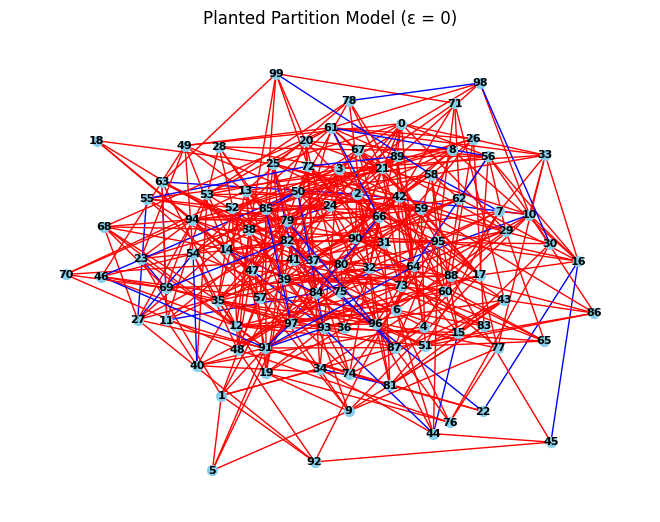

Mean Degree for ε = 4: 8.38
Modularity for ε = 4: 0.0352
C (in): 60
C (out): 359


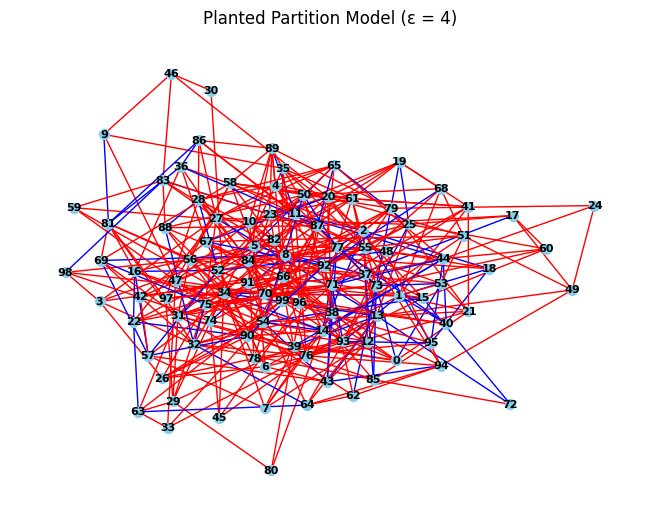

Mean Degree for ε = 8: 6.76
Modularity for ε = 8: 0.0737
C (in): 65
C (out): 273


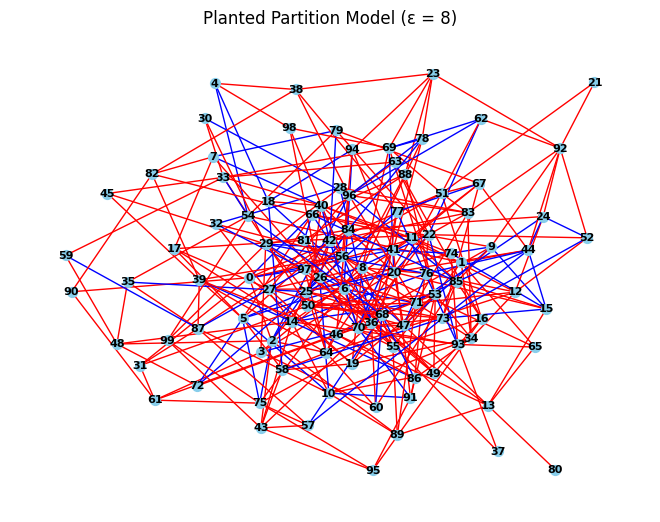

Mean Degree for ε = 12: 4.92
Modularity for ε = 12: 0.1487
C (in): 63
C (out): 183


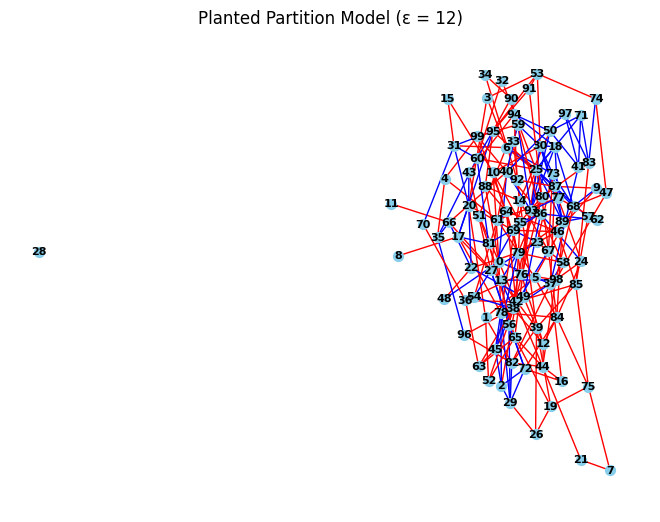

In [34]:
np.random.seed(123)

for epsilon in EPSILONS:
    G, communities = planted_partition_model(N, K, D, epsilon)

    mean_degree = np.mean(list(dict(G.degree()).values()))
    print(f'Mean Degree for ε = {epsilon}: {mean_degree:.2f}')

    # Calculate number of community edges
    c = [0,0,0]
    
    for i,j, in G.edges():
        if communities[i] == 0 and communities[j] == 0:
            c[0] += 1 # Number of In Edges for Group 1
        elif communities[i] == 1 and communities[j] == 1:
            c[1] += 1 # Number of In Edges for Group 2
        else:
            c[2] += 1 # Number of Cross Community Edges

    #Calculate total community degrees            
    k0 = 0
    k1 = 0

    for i, j in G.edges:
        if communities[i] == 0:
            k0 += 1
        if communities[j] == 0:
            k0 += 1
        if communities[i] == 1:
            k1 += 1
        if communities[j] == 1:
            k1 += 1
    
    # Calculating Modularity
    m = sum(c)
    modularity = c[0]/m - (k0/2 / m)**2 + c[1] / m - (k1 / 2/ m)**2
    print(f'Modularity for ε = {epsilon}: {modularity:.4f}')

    print(f'C (in): {c[1] + c[0]}')
    print(f'C (out): {c[2]}')
    

    #Plot graph with pretty edge colors      
    pos = nx.spring_layout(G)
    edge_colors = ['red' if communities[i] != communities[j] else 'blue' for i, j in G.edges()]
    
    plt.figure()
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=8, font_color='black', font_weight='bold', edge_color= edge_colors, node_color='skyblue')
    plt.title(f'Planted Partition Model (ε = {epsilon})')
    plt.show()

## Part B

In [5]:
def initializePandemic(G):
    N = len(G.nodes())
    firstInfected = np.random.randint(low=0, high=N)
    infected_nodes = set()
    infected_nodes.add(firstInfected)
    print(f"First Infected: Person {firstInfected} \n")
    return infected_nodes

def runIteration(G,p, infected_nodes, new_infected):
    next_infected = set()
    for i in new_infected.copy():
        for j,k in G.edges:            
            if i == j and k not in infected_nodes:
                if np.random.rand() < p:
                    infected_nodes.add(k)
                    next_infected.add(k)
            if i == k and j not in infected_nodes:
                if np.random.rand() < p:
                    infected_nodes.add(j)
                    next_infected.add(j)
    new_infected = next_infected
    return infected_nodes, new_infected

### Creating the COVID class

This class is a pandemic object.

1. Create the graph
2. Intialize (randomly select someone to be the first infected)
3. Start Covid

When starting Covid, if printGraphs is set to "True", you can visualize the pandemic spreading throughout the network.

In [36]:
class COVID():
    def __init__(self) -> None:
        self.G = None
        self.infected_nodes = None
        self.new_infected = None
        self.rounds = None
        self.communities = None
        self.p = None
        self.N = None #Number of nodes
        
    def createGraph(self, N,K,D,EPSILON):
        self.G, self.communities = planted_partition_model(N,K,D,EPSILON)
        self.N = N
        return
        
    def initialize(self, printMessage = True):
        self.rounds = 1
        N = len(self.G.nodes())
        firstInfected = np.random.randint(low=0, high=N)
        infected_nodes = set()
        infected_nodes.add(firstInfected)
        self.infected_nodes = infected_nodes
        self.new_infected = infected_nodes
        if printMessage == True:
            print(f"First Infected: Person {firstInfected} \n")
            self.print()
        return
        
    def print(self):
        pos = nx.spring_layout(self.G)
        pos = nx.spring_layout(self.G)
        node_colors = ['red' if node in self.infected_nodes else 'blue' for node in self.G.nodes]
        nx.draw(self.G, pos, node_size=50, font_size=8, font_color='black', font_weight='bold', node_color=node_colors, edge_color='gray')
        plt.title(f'Planted Partition Model (Round {self.rounds-1})')
        plt.show()
        plt.pause(3)
        return
    
    def startCovid(self, p, iterations, printGraphs = False):
        self.rounds = 1
        self.p = p
        while self.rounds != iterations+1:
            
            self.infected_nodes, self.new_infected = runIteration(self.G, p = p, infected_nodes= self.infected_nodes, new_infected= self.new_infected)
            
            if len(self.infected_nodes) == self.N:
                if printGraphs == True:
                    clear_output()
                    print(f"Round {self.rounds}:")
                    print(f"Newly Infected: {len(self.new_infected)}")
                    print(f"Total Infected: {len(self.infected_nodes)} \n")
                    print("That's Everyone :(")
                    self.print()
                    print(f"Convergence in Round {self.rounds}")
                    break
                else:
                    print(f"Convergence in Round {self.rounds}")
                    break
            
            elif printGraphs == True:
                if len(self.new_infected) == 0:
                    self.rounds -= 1
                    print(f"Convergence in Round {self.rounds}")
                    break
                else:
                    clear_output()
                    print(f"Round {self.rounds}:")
                    print(f"Newly Infected: {len(self.new_infected)}")
                    print(f"Total Infected: {len(self.infected_nodes)} \n")
                    self.rounds += 1
                self.print()
                
            else:
                if len(self.new_infected) == 0:
                    self.rounds -= 1 
                    print(f"Convergence in Round {self.rounds}")
                    break
                else:
                    self.rounds += 1
        return    

Setting Parameters

In [7]:
N = 1000
K = 2
D = 8
EPSILONS = 0

## Trial Run

In [8]:
# making a trial graph
# if you run the code you can watch the network get infected over tiem
trial = COVID()
trial.createGraph(N = 1000, K =2, D = 8, EPSILON= 0)
trial.initialize(printMessage = True)
trial.startCovid(p = 0.5, iterations = 100, printGraphs = True)

Round 2:
Newly Infected: 14
Total Infected: 20 



KeyboardInterrupt: 

## Graphing Pandemic Lengths:

I am generating 100 random probabilities between 0 and 1. This is the independent probability of transmission between connected nodes.

For each probability, I generate a new graph and start a pandemic.

In [ ]:
np.random.seed(1234)

probabilities = np.random.rand(100)

l = []
infected = []
q1b = COVID()

for p in probabilities:
    print(f"Probability of Infection: {p:.2f}")
    q1b.createGraph(N = 1000, K =2, D = 8, EPSILON= 0)
    q1b.initialize(printMessage = False)
    q1b.startCovid(p = p, iterations = 100, printGraphs = False)
    print("")
    l.append(q1b.rounds)
    infected.append(len(q1b.infected_nodes))
    

Probability of Infection: 0.19
Convergence in Round 24

Probability of Infection: 0.62
Convergence in Round 7

Probability of Infection: 0.44
Convergence in Round 9

Probability of Infection: 0.79
Convergence in Round 6

Probability of Infection: 0.78
Convergence in Round 6

Probability of Infection: 0.27
Convergence in Round 16

Probability of Infection: 0.28
Convergence in Round 13

Probability of Infection: 0.80
Convergence in Round 6

Probability of Infection: 0.96
Convergence in Round 5

Probability of Infection: 0.88
Convergence in Round 5

Probability of Infection: 0.36
Convergence in Round 10

Probability of Infection: 0.50
Convergence in Round 9

Probability of Infection: 0.68
Convergence in Round 6

Probability of Infection: 0.71
Convergence in Round 7

Probability of Infection: 0.37
Convergence in Round 10

Probability of Infection: 0.56
Convergence in Round 7

Probability of Infection: 0.50
Convergence in Round 0

Probability of Infection: 0.01
Convergence in Round 0

Proba

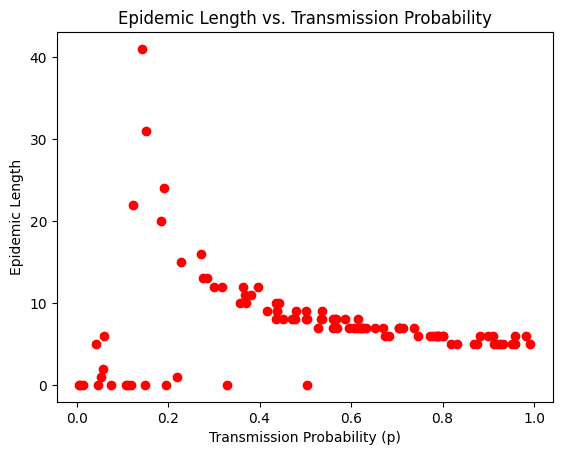

In [ ]:
plt.scatter(probabilities, l, color='red')
plt.xlabel('Transmission Probability (p)')
plt.ylabel('Epidemic Length')
plt.title('Epidemic Length vs. Transmission Probability')
plt.show()

## Analysis:

In this graph, we see a graph that starts very low, peaks around 0.2, and then asymptotically approaches somehwere between 5 and 7.

For the max, at a probability of 0.2, it took around 30 iterations before the last person was infected.

Understandably, at the very extremes, the epidemic lengths are very low. At 0% percent probabililty, the pandemic never spreads. At 100% probability, the maxmimum iterations is the diameter of the component containing the initial person.

There is a large split around 0.15 - 0.25. This is presumably the split between pandemics that become contained vs. pandemic that spread. I will simulate more examples with special emphasis on this region to explore more. If this interpration is correct, this implies that if the pandemic at this level is not contained within a certain number of interations (in this graph, it is around 5-8), it will continue to inevitably spread to everyone (albeit slowly).

Addendum:

Probability of Infection: 0.19
Convergence in Round 24

Probability of Infection: 0.62
Convergence in Round 7

Probability of Infection: 0.44
Convergence in Round 9

Probability of Infection: 0.79
Convergence in Round 6

Probability of Infection: 0.78
Convergence in Round 6

Probability of Infection: 0.27
Convergence in Round 16

Probability of Infection: 0.28
Convergence in Round 13

Probability of Infection: 0.80
Convergence in Round 6

Probability of Infection: 0.96
Convergence in Round 5

Probability of Infection: 0.88
Convergence in Round 5

Probability of Infection: 0.36
Convergence in Round 10

Probability of Infection: 0.50
Convergence in Round 9

Probability of Infection: 0.68
Convergence in Round 6

Probability of Infection: 0.71
Convergence in Round 7

Probability of Infection: 0.37
Convergence in Round 10

Probability of Infection: 0.56
Convergence in Round 7

Probability of Infection: 0.50
Convergence in Round 0

Probability of Infection: 0.01
Convergence in Round 0

Proba

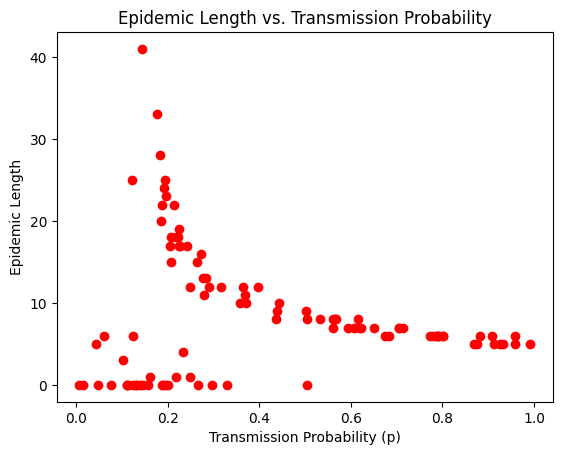

In [ ]:
np.random.seed(1234)

#Concentrating probabilities between 0.1 and 0.3
random_numbers1 = np.random.rand(60)
random_numbers2 = np.random.uniform(low=0.1, high=0.3, size=40)

combined_list = list(random_numbers1) + list(random_numbers2)
l1 = []
infected1 = []
q1b = COVID()

for p in combined_list:
    print(f"Probability of Infection: {p:.2f}")
    q1b.createGraph(N = 1000, K =2, D = 8, EPSILON= 0)
    q1b.initialize(printMessage = False)
    q1b.startCovid(p = p, iterations = 1000, printGraphs = False)
    print("")
    l1.append(q1b.rounds)
    infected1.append(len(q1b.infected_nodes))

plt.scatter(combined_list, l1, color='red')
plt.xlabel('Transmission Probability (p)')
plt.ylabel('Epidemic Length')
plt.title('Epidemic Length vs. Transmission Probability')
plt.show()    

## Graphing Pandemic Size

Using the data generated from the first simulation

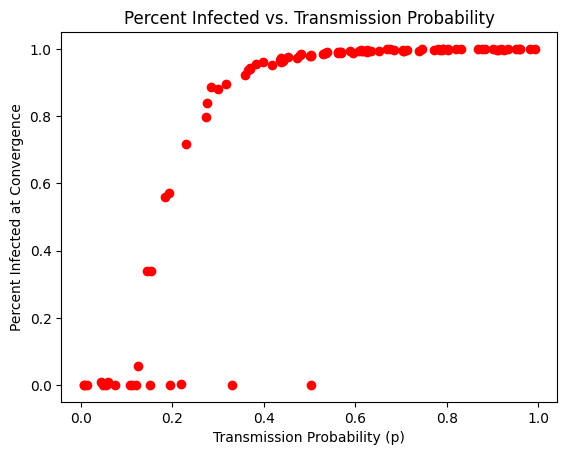

In [ ]:
infected_percent = np.array(infected)/N

plt.scatter(probabilities, infected_percent, color='red')
plt.xlabel('Transmission Probability (p)')
plt.ylabel('Percent Infected at Convergence')
plt.title('Percent Infected vs. Transmission Probability')
plt.show()

## Analysis:

Of course, as the probability increases, the percentage of the population infected reaches close to 100%. At 100% transmission, everyone within the component will become infected. With low probabilities, the pandemic will be contained.there seems to be a key point at around 20% again (same as above), where the graph starts growing logarithmically. Once again I will use the dataset with extra probabilities around this region for a closer look.

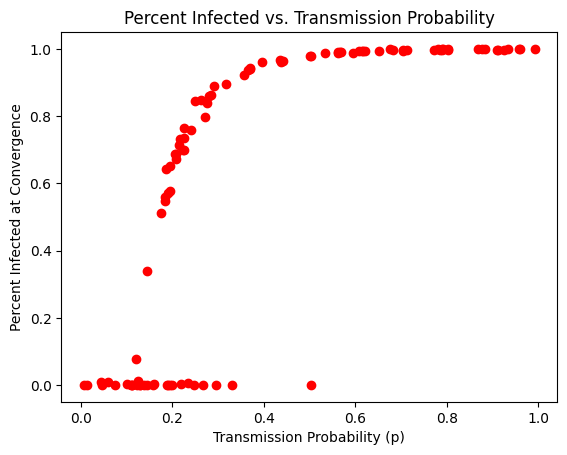

In [ ]:
infected1_percent = np.array(infected1)/N
sorted_indices = np.argsort(combined_list)
sorted_probabilities = np.array(combined_list)[sorted_indices]
sorted_infected1 = infected1_percent[sorted_indices]

plt.scatter(combined_list, infected1_percent, color='red')
plt.xlabel('Transmission Probability (p)')
plt.ylabel('Percent Infected at Convergence')
plt.title('Percent Infected vs. Transmission Probability')
plt.show()

## Part C

For each of 6 probabilites, I generate 20 random $\epsilon$.

In [ ]:
N = 200
K = 2
D = 8

In [ ]:
probabilities = [0.1,0.2,0.3,0.5,0.75,1]
epsilon = np.random.uniform(low = 0, high = 2*K, size = 40)

l3 = []
infected3 = []
q1c = COVID()

for p in probabilities:
    pl =[] # list of pandemic lengths given probability p
    pi = [] # list of infected given probaility p
    for e in epsilon:    
        print(f"Probability of Infection: {p:.2f}")
        q1b.createGraph(N = N, K =K, D = D, EPSILON= e)
        q1b.initialize(printMessage = False)
        q1b.startCovid(p = p, iterations = 100, printGraphs = False)
        print("")
        pl.append(q1b.rounds)
        pi.append(len(q1b.infected_nodes))
    l3.append(pl)
    infected3.append(pi)

Probability of Infection: 0.10
Convergence in Round 5

Probability of Infection: 0.10
Convergence in Round 0

Probability of Infection: 0.10
Convergence in Round 0

Probability of Infection: 0.10
Convergence in Round 0

Probability of Infection: 0.10
Convergence in Round 3

Probability of Infection: 0.10
Convergence in Round 1

Probability of Infection: 0.10
Convergence in Round 0

Probability of Infection: 0.10
Convergence in Round 0

Probability of Infection: 0.10
Convergence in Round 0

Probability of Infection: 0.10
Convergence in Round 5

Probability of Infection: 0.10
Convergence in Round 1

Probability of Infection: 0.10
Convergence in Round 3

Probability of Infection: 0.10
Convergence in Round 0

Probability of Infection: 0.10
Convergence in Round 2

Probability of Infection: 0.10
Convergence in Round 7

Probability of Infection: 0.10
Convergence in Round 0

Probability of Infection: 0.10
Convergence in Round 2

Probability of Infection: 0.10
Convergence in Round 4

Probabilit

### Graphing Epidemic Length across $\epsilon$

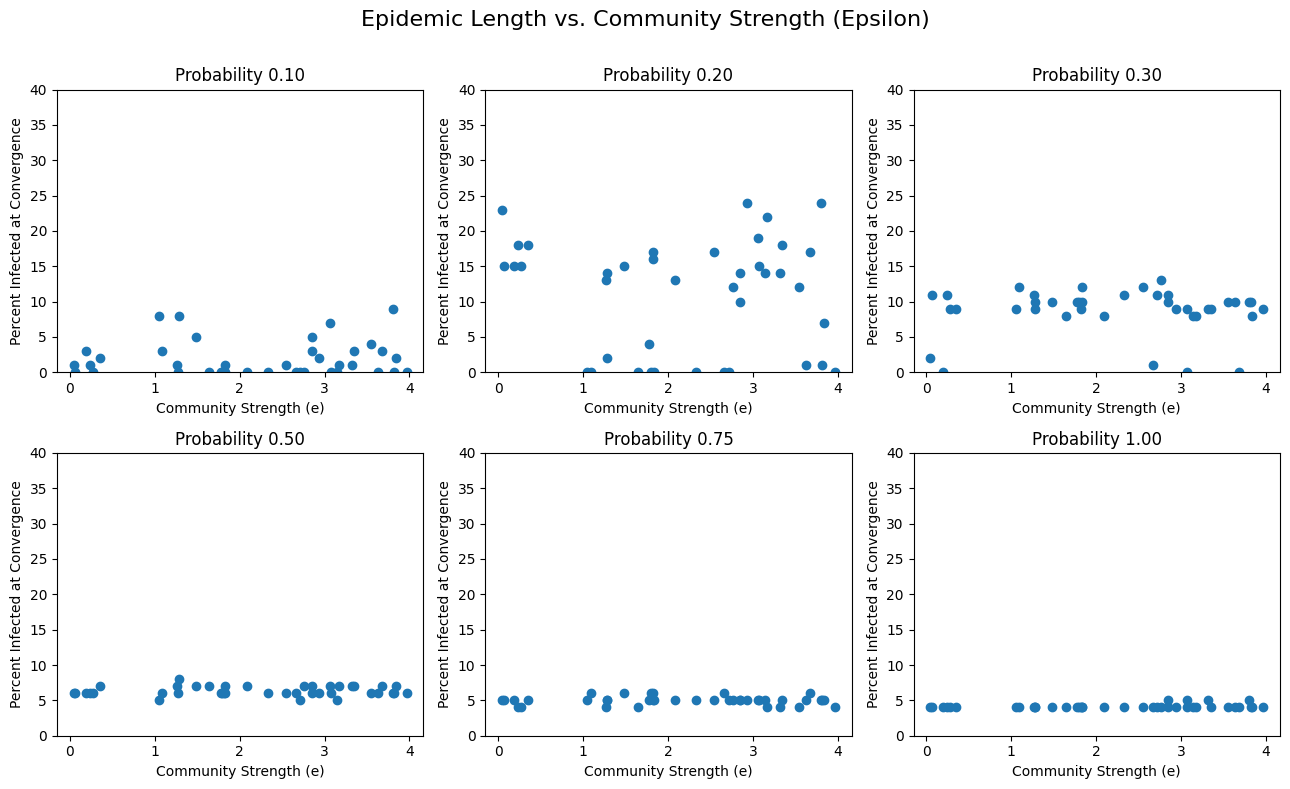

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(13, 8))
axs = axs.flatten()

for i in range(len(l3)):
    axs[i].scatter(x=epsilon, y=l3[i])
    axs[i].set_title(f'Probability {probabilities[i]:.2f}')
    axs[i].set_xlabel('Community Strength (e)')
    axs[i].set_ylabel('Percent Infected at Convergence')
    axs[i].set_ylim(0, 40)
plt.suptitle(f'Epidemic Length vs. Community Strength (Epsilon)\n', fontsize = 16)
plt.tight_layout()
plt.show()

#### Graphing Percent Infected across $\epsilon$

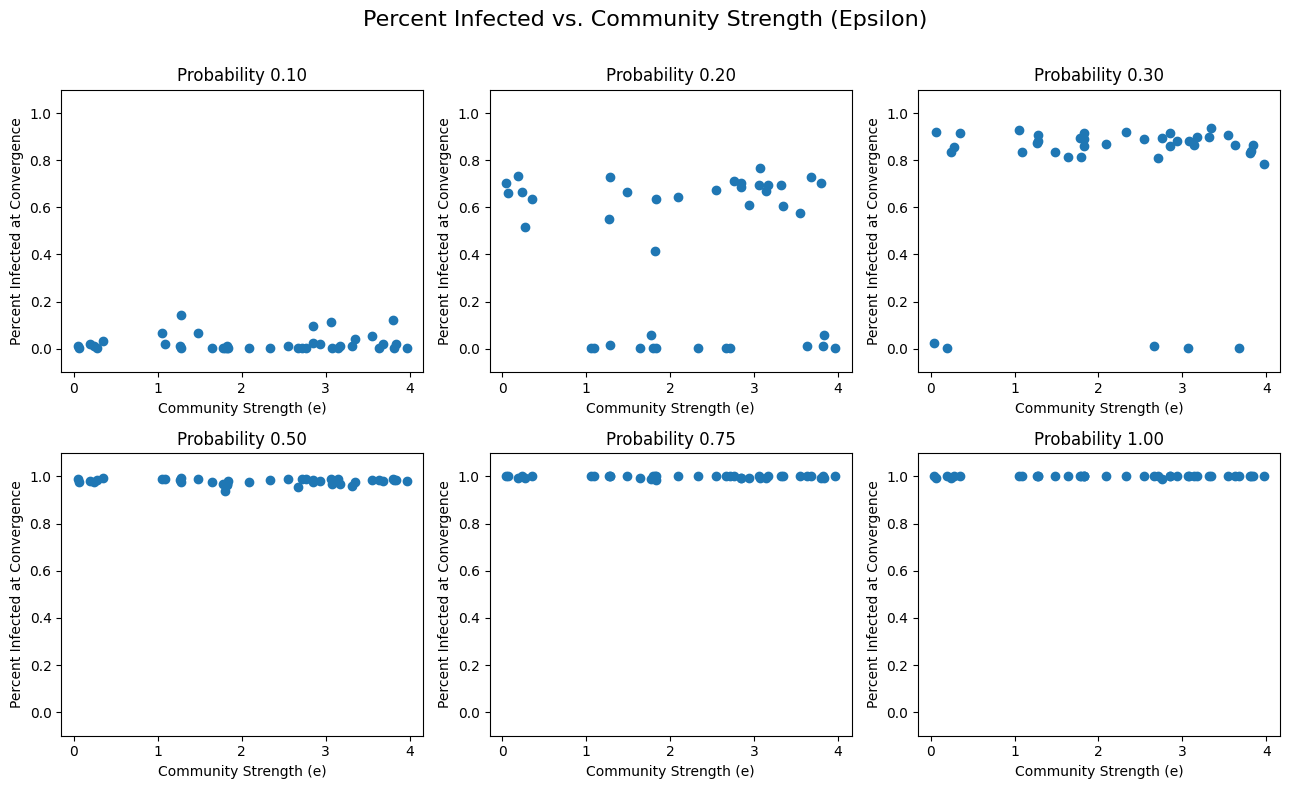

In [ ]:
infected3_percent = np.array(infected3)/N

fig, axs = plt.subplots(2, 3, figsize=(13, 8))
axs = axs.flatten()

for i in range(len(infected3_percent)):
    axs[i].scatter(x=epsilon, y=infected3_percent[i])
    axs[i].set_title(f'Probability {probabilities[i]:.2f}')
    axs[i].set_xlabel('Community Strength (e)')
    axs[i].set_ylabel('Percent Infected at Convergence')
    axs[i].set_ylim(-0.1, 1.1)
plt.suptitle(f'Percent Infected vs. Community Strength (Epsilon)\n', fontsize = 16)
plt.tight_layout()
plt.show()

## Analysis:

There is clearly no relationship between varying community strength and pandemic length/percent infected. While the community strength varies, the mean degree, and therefore the total degree is hedl relatively constant. 

This implies two things:
1. It will be more difficult for the infection in one community to reach the other as there are fewer "out" edges.
2. The infection will spread more quickly wihtin communities as there are more "in" edges.

Ultimately there are the same number of bridges in the total network and the probability of each of those bridges remains constant. Therefore, the percent of people infected certainly won't change and the length of the epidemic should not change either.

Visualization:

Round 7:
Newly Infected: 5
Total Infected: 998 



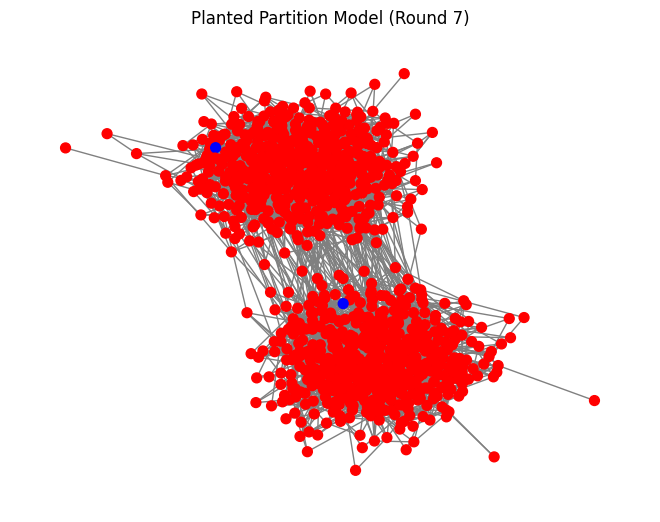

Convergence in Round 7


In [ ]:
np.random.seed(123)

trial = COVID()
trial.createGraph(N = 1000, K =2, D = 8, EPSILON= 15)
trial.initialize(printMessage = True)
trial.startCovid(p = 0.8, iterations = 100, printGraphs = True)

Even in this example which is far more extereme than the examples above (as we capped epsilon as 2 times of $K$), we see that as soon as the disease comes over in to the other partition, it takes absolutely no time at all before everyone on both sides is infected. Let's compare this to the spread of a graph with low Epsilon.

In [9]:
np.random.seed(12) #seed changed because 123 has someone with degree 0

trial = COVID()
trial.createGraph(N = 1000, K =2, D = 8, EPSILON= 0)
trial.initialize(printMessage = True)
trial.startCovid(p = 0.8, iterations = 100, printGraphs = True)

Round 1:
Newly Infected: 4
Total Infected: 5 



KeyboardInterrupt: 

So after playing around with different seeds, I see that with these extremes, graph 1 consistently converges in Round 7 where as graph 2 consistently converges in Round 6. As rounds must be integer numbers and even at such extremes in terms of both epsilon and probability, it follows as to why our more moderate range of epsilons returns uniform result.

There is aboslutely no difference though in the percent of people infected.


Round 5:
Newly Infected: 32
Total Infected: 499 



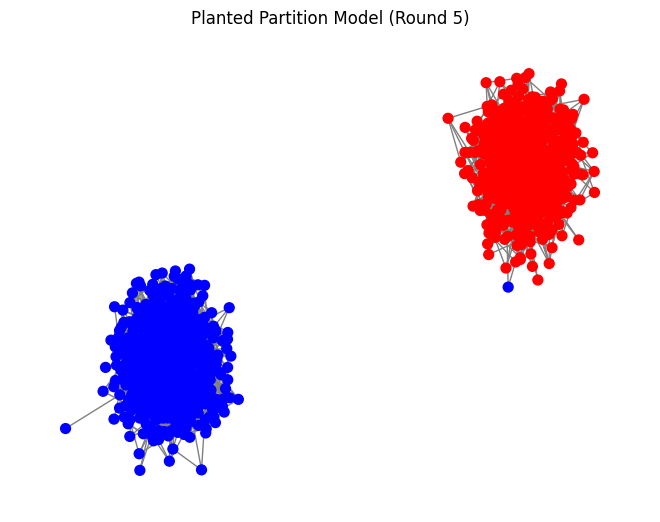

Convergence in Round 5


In [ ]:
np.random.seed(12) #seed changed because 123 has someone with degree 0

trial = COVID()
trial.createGraph(N = 1000, K =2, D = 8, EPSILON= 19)
trial.initialize(printMessage = True)
trial.startCovid(p = 0.8, iterations = 100, printGraphs = True)

Out of curiousity, I put in the super extreme case where you have completely separate communities. Of course in this case, the chance that you have the same percent of infected people is 0%. However, it suprised me that the number of rounds was not that far off at only 5. It does make sense also that with smaller community, there is a slower spread as there are fewer edges and ndoes For example, most infected in a round for the previous graph was over 500 where, for this graph, the max is 226.

I also noticed that if you ignore the completely disconnected community the ratio stays the same. Perhaps the calculation of infected ratio as:

$$
\left< \frac{s}{n} \right>
$$

would be more accurate $n$ was the size of the infected cluster rather than the entire graph.

Just for fun I'm going to try this with a graph that only has one bridge inbetween clusters.

In [78]:
np.random.seed(12) #seed changed because 123 has someone with degree 0

trial = COVID()
trial.createGraph(N = 1000, K =3, D = 9.5, EPSILON= 17)
trial.initialize(printMessage = True)
trial.startCovid(p = 0.8, iterations = 100, printGraphs = True)

Round 6:
Newly Infected: 186
Total Infected: 988 

